# CNN1D parameter exploration
This notebook is a template for finding the CNN1D model best suited for your needs

This architecture is based in the CNN1D designed by A. Navas-Olivé (https://doi.org/10.7554/eLife.77772).
This arquitecture is inspired by the UNet (https://doi.org/10.48550/arXiv.1505.04597) and YOLOR (https://doi.org/10.48550/arXiv.2105.04206)
The 1st half uses convolution and MaxPooling to reduce the dimnensinality of the input, and the late half expands it

In [21]:
import os
import importlib
import matplotlib.pyplot as plt
import numpy as np
import sys
parent_dir=os.path.dirname(os.getcwd())
sys.path.insert(0,parent_dir)
import rippl_AI
import aux_fcn
importlib.reload(aux_fcn)
importlib.reload(rippl_AI)

<module 'rippl_AI' from 'c:\\SWR_repo\\rippl_AI.py'>

### Data download
4 uLED sessions will be downloaded: Amigo2 and Som2 will be used for training ; Dlx1 and Thy7 for validation


In [ ]:
from figshare.figshare.figshare import Figshare
fshare = Figshare()

article_ids = [16847521,16856137,14959449,14960085] 
sess=['Amigo2','Som2','Dlx1','Thy7']                                  
for id,s in zip(article_ids,sess):
    datapath = os.path.join(parent_dir,'Downloaded_data', f'{s}')
    if os.path.isdir(datapath):
        print(f"{s} session already exists. Moving on.")
    else:
        print("Downloading data... Please wait, this might take up some time")        # Can take up to 10 minutes
        fshare.retrieve_files_from_article(id,directory=datapath)
        print("Data downloaded!")

### Data load
The training sessions' LFP will be appended together in a list. The same will happen with the ripples detection times.
That is the required input for the training parser

In [2]:
# The training sessions will be appended together. Replace this cell with your own data loading
train_LFPs=[]
train_GTs=[]
# Amigo2
path=os.path.join(parent_dir,'Downloaded_data','Amigo2','figshare_16847521')
LFP,GT=aux_fcn.load_lab_data(path)
train_LFPs.append(LFP)
train_GTs.append(GT)
# Som2
path=os.path.join(parent_dir,'Downloaded_data','Som2','figshare_16856137')
LFP,GT=aux_fcn.load_lab_data(path)
train_LFPs.append(LFP)
train_GTs.append(GT)

## Append all your validation sessions
val_LFPs=[]
val_GTs=[]
# Dlx1 Validation
path=os.path.join(parent_dir,'Downloaded_data','Dlx1','figshare_14959449')
LFP,GT=aux_fcn.load_lab_data(path)
val_LFPs.append(LFP)
val_GTs.append(GT)
# Thy07 Validation
path=os.path.join(parent_dir,'Downloaded_data','Thy7','figshare_14960085')
LFP,GT=aux_fcn.load_lab_data(path)
val_LFPs.append(LFP)
val_GTs.append(GT)

x_training,GT_training,x_val_list,GT_val_list=rippl_AI.prepare_training_data(train_LFPs,train_GTs,val_LFPs,val_GTs,sf=30000)

c:\SWR_repo\Downloaded_data\Amigo2\figshare_16847521/hippo_2019-07-11_11-57-07_1150um_shank3.dat
fileStart  0
fileStop  1151451136
nSamples  575725568
nSamplesPerChannel  71965696
nSamplesPerChunk  10000
size data  71965696
c:\SWR_repo\Downloaded_data\Som2\figshare_16856137/hippo_2019-07-24_12-01-49_1530um_shank3.dat
fileStart  0
fileStop  497401856
nSamples  248700928
nSamplesPerChannel  31087616
nSamplesPerChunk  10000
size data  31087616
c:\SWR_repo\Downloaded_data\Dlx1\figshare_14959449/lfp_Dlx1-2021-02-12_12-46-54.dat
fileStart  0
fileStop  490242048
nSamples  245121024
nSamplesPerChannel  30640128
nSamplesPerChunk  10000
size data  30640128
c:\SWR_repo\Downloaded_data\Thy7\figshare_14960085/lfp_Thy7-2020-11-11_16-05-00.dat
fileStart  0
fileStop  357220352
nSamples  178610176
nSamplesPerChannel  22326272
nSamplesPerChunk  10000
size data  22326272
Original training data shape:  (71965696, 8)
Downsampling data at 1250 Hz...
Shape of downsampled data: (2998571, 8)
Normalizing data..

## CNN1D training parameters

#### Parameters:
* Channels:  number of channels that will be used to train the model, extracted from the data shape defined in the previous cell
* Timesteps: number of samples that the model will use to produce a single output
* Configuration: list with as many elements as layers in the model shaped [number of kernels layers, kernel size and stride ]. The length size and the kernel layer were matched to reduce design complexity.
* Epoch: number of times the training data set is used to train the model
* Training batch: number of windows that are proccessed before weight updating

In [23]:
conf= {"timesteps":   [16],        # 16, 32, 64 ...
      "configuration":      [[[4,2],[2,1],[8,2],[4,1],[16,2],[8,1],[32,2]],  
                     [[4,4],[2,1],[8,2],[4,1],[16,2],[8,1],[32,2]]],  
      "epochs":      [1],         # 1, 2, 3, 5...
      "train_batch": [2**5],      # 32, 64, 128...
}

### Training

In [24]:
# Desired sampling frequency of the models
sf=1250
th_arr=np.linspace(0.1,0.9,9)
model_name_arr=[]           # To plot in the next cell
model_arr=[]                # Actual model array, used in the next validation section
n_channels=x_training.shape[1]
timesteps_arr=conf['timesteps']

config_arr=conf['configuration']
epochs_arr=conf['epochs']
train_batch_arr=conf['train_batch']   

l_ts=len(timesteps_arr)
l_conf=len(config_arr)
l_epochs =len(epochs_arr)
l_batch =len(train_batch_arr)
n_iters=l_ts*l_conf*l_epochs*l_batch
# GT is in the shape (n_events x 2), a y output signal with the same length as x is required
perf_train_arr=np.zeros(shape=(n_iters,len(th_arr),3)) # Performance array, (n_models x n_th x 3 ) [P R F1]
perf_test_arr=np.zeros_like(perf_train_arr)
timesteps_arr_ploting=[]            # Array that will be used in the validation, to be able to call the function predict

print(f'{n_channels} channels will be used to train the CNN1D models')

print(f'{n_iters} models will be trained')

x_test_or,GT_test,x_train_or,GT_train=aux_fcn.split_data(x_training,GT_training,split=0.7,sf=sf)

y_test_or= np.zeros(shape=(len(x_test_or)))
for ev in GT_test:
    y_test_or[int(sf*ev[0]):int(sf*ev[1])]=1
y_train_or= np.zeros(shape=(len(x_train_or)))
for ev in GT_train:
    y_train_or[int(sf*ev[0]):int(sf*ev[1])]=1


for i_ts,timesteps in enumerate(timesteps_arr):
    x_train=x_train_or[:len(x_train_or)-len(x_train_or)%timesteps].reshape(-1,timesteps,n_channels)
    y_train_aux=y_train_or[:len(y_train_or)-len(y_train_or)%timesteps].reshape(-1,timesteps)
    x_test=x_test_or[:len(x_test_or)-len(x_test_or)%timesteps].reshape(-1,timesteps,n_channels)
    y_test_aux=y_test_or[:len(y_test_or)-len(y_test_or)%timesteps].reshape(-1,timesteps)

    y_train=np.zeros(shape=[x_train.shape[0],1])
    for i in range(y_train_aux.shape[0]):
        y_train[i]=1  if any (y_train_aux[i]==1) else 0
    print("Train Input and Output dimension", x_train.shape,y_train.shape)
    
    y_test=np.zeros(shape=[x_test.shape[0],1])
    for i in range(y_test_aux.shape[0]):
        y_test[i]=1  if any (y_test_aux[i]==1) else 0

    for i_conf, configuration in enumerate(config_arr):
        for i_epochs,epochs in enumerate(epochs_arr):
            for i_batch,train_batch in enumerate(train_batch_arr):
                iter=((i_ts*l_conf+i_conf)*l_epochs + i_epochs)*l_batch + i_batch
                print(f"\nIteration {iter+1} out of {n_iters}")
                print(f'Number of channels: {n_channels:d}, Time steps: {timesteps:d},\nconfiguration: {configuration}\nEpochs: {epochs:d}, Samples per batch: {train_batch:d}')

                model = aux_fcn.build_CNN1D(n_channels,timesteps,configuration)
                # Training
                model.fit(x_train, y_train,shuffle=False, epochs=epochs,batch_size=train_batch,validation_data=(x_test,y_test), verbose=1)
                model_arr.append(model)
                # Prediction
                test_signal = model.predict(x_test,verbose=1)
                train_signal=model.predict(x_train,verbose=1)

                y_train_predict=np.empty(shape=(x_train.shape[0]*timesteps,1,1))
                for i,window in enumerate(train_signal):
                    y_train_predict[i*timesteps:(i+1)*timesteps]=window
                y_test_predict=np.empty(shape=(x_test.shape[0]*timesteps,1,1))
                for i,window in enumerate(test_signal):
                    y_test_predict[i*timesteps:(i+1)*timesteps]=window

                ############################
                for i,th in enumerate(th_arr):
                    # Test
                    ytest_pred_ind=aux_fcn.get_predictions_index(y_test_predict,th)/sf
                    perf_test_arr[iter,i]=aux_fcn.get_performance(ytest_pred_ind,GT_test,0)[0:3]
                    # Train
                    ytrain_pred_ind=aux_fcn.get_predictions_index(y_train_predict,th)/sf
                    perf_train_arr[iter,i]=aux_fcn.get_performance(ytrain_pred_ind,GT_train,0)[0:3]

                    # Saving the model
                    model_name=f"CNN1D_Ch{n_channels:d}_Ts{timesteps:03d}_C{i_conf:02d}_E{epochs:02d}_TB{train_batch:04d}"
                    model.save(os.path.join(parent_dir,'explore_models',model_name))

                    model_name_arr.append(model_name)
                    timesteps_arr_ploting.append(timesteps)

8 channels will be used to train the CNN1D models
2 models will be trained
Train Input and Output dimension (220312, 16, 8) (220312, 1)

Iteration 1 out of 2
Number of channels: 8, Time steps: 16,
configuration: [[4, 2], [2, 1], [8, 2], [4, 1], [16, 2], [8, 1], [32, 2]]
Epochs: 1, Samples per batch: 32


IndexError: list index out of range

### Plot training results

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

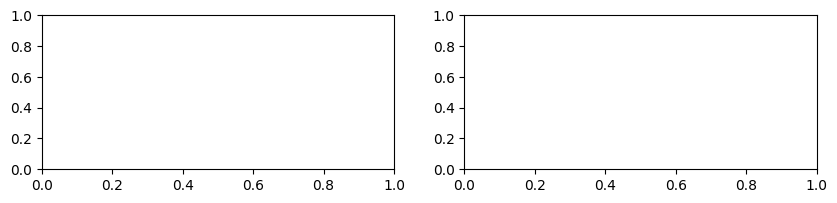

In [20]:
# Plot training results
fig,axs=plt.subplots(n_iters,2,figsize=(10,2*n_iters),sharey='col',sharex='col')

for i in range(n_iters):
    axs[i,0].plot(perf_train_arr[i,:,0],perf_train_arr[i,:,1],'k.-')
    axs[i,0].plot(perf_test_arr[i,:,0],perf_test_arr[i,:,1],'b.-')
    axs[i,1].plot(th_arr,perf_train_arr[i,:,2],'k.-')
    axs[i,1].plot(th_arr,perf_test_arr[i,:,2],'b.-')
    axs[i,0].set_title(model_name_arr[i])
    axs[i,0].set_ylabel('Precision')
    axs[i,1].set_ylabel('F1')
axs[-1,0].set_xlabel('Recall')
axs[-1,1].set_xlabel('Threshold')
axs[0,0].legend(['Training','Test'])
plt.show()

### Validation

In [ ]:
# For loop iterating over the models
fig,axs=plt.subplots(n_iters,2,figsize=(10,2*n_iters),sharey='col',sharex='col')
for n_m,model in enumerate(model_arr):
    F1_arr=np.zeros(shape=(len(x_val_list),len(th_arr))) #(n_val_sess x n_th) Array where the F1 val of each sesion will be stored
    for n_sess,LFP in enumerate(x_val_list):
        val_pred=rippl_AI.predict(LFP,sf=1250,arch='CNN1D',new_model=model,n_channels=n_channels,n_timesteps=timesteps_arr_ploting[n_m])[0]
        for i,th in enumerate(th_arr):
            val_pred_ind=aux_fcn.get_predictions_index(val_pred,th)/sf
            F1_arr[n_sess,i]=aux_fcn.get_performance(val_pred_ind,GT_val_list[n_sess],verbose=False)[2]
    
    axs[n_m,0].plot(th_arr,perf_train_arr[n_m,:,2],'k.-')
    axs[n_m,0].plot(th_arr,perf_test_arr[n_m,:,2],'b.-')
    for F1 in F1_arr:
        axs[n_m,1].plot(th_arr,F1)
    axs[n_m,1].plot(th_arr,np.mean(F1_arr,axis=0),'k.-')
    axs[n_m,0].set_title(model_name_arr[n_m])
    axs[n_m,0].set_ylabel('Precision')
    axs[n_m,1].set_ylabel('F1')
axs[-1,0].set_xlabel('Recall')
axs[-1,1].set_xlabel('Threshold')
plt.show()
    